# 深層学習によるデータの学習・評価

Pytorch で深層学習モデルを構築し、データを学習・評価する．

In [1]:
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
import sklearn as sk
import sklearn.model_selection as skms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

In [17]:
class AquatanBleDataset(torch.utils.data.Dataset):
    def __init__(self, data_paths: list[str], groupby: str | list[str] | None = None, n_samples: int | None = None, random_state: int = 0):
        self.df = pd.concat([pd.read_csv(data_path) for data_path in data_paths], ignore_index=True)
        if groupby is not None:
            self.df = self.df.groupby(groupby).sample(n=n_samples, random_state=random_state)
        self.X = torch.tensor(self.df.drop(columns=["label", "ble_id"]).values, dtype=torch.float32)
        self.t = torch.tensor(pd.get_dummies(self.df["label"]).values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.t[idx]
    
    def number_of_used_datas(self):
        return self.df["label"].value_counts()

In [3]:
# 深層学習モデルの定義
class AquatanBleNN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super(AquatanBleNN, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.fc_layers(x)
        return x

In [4]:
# 訓練関数
def train(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    n_epochs: int,
    device: torch.device = torch.device("cpu")
):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    model.to(device)
    
    for _ in range(n_epochs):
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        model.train()
        # ミニバッチ学習
        for x, t in train_loader:
            x, t = x.to(device), t.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, t)
            loss.backward()
            optimizer.step()

            # トレインデータでの評価
            train_loss += loss.item()
            argmax_y = torch.argmax(y, dim=1)
            argmax_t = torch.argmax(t, dim=1)
            train_acc += torch.sum(argmax_y == argmax_t).item()
        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)

        # テストデータでの評価
        model.eval()
        x, t = next(iter(test_loader))
        x, t = x.to(device), t.to(device)
        y = model(x)
        loss = criterion(y, t)
        test_loss = loss.item()
        argmax_y = torch.argmax(y, dim=1)
        argmax_t = torch.argmax(t, dim=1)
        test_acc = torch.sum(argmax_y == argmax_t).item() / len(t)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

    return train_losses, test_losses, train_accs, test_accs

In [5]:
def plot_mean_std(ax, y, label):
    y = np.array(y)
    mean = np.mean(y, axis=0)
    std = np.std(y, axis=0)
    ax.plot(mean, label=label)
    ax.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2)

## 前処理の効果を確認

../windowed, t=180 finished
../windowed, t=240 finished
../windowed_boxcox, t=180 finished
../windowed_boxcox, t=240 finished
../reducted, t=180 finished
../reducted, t=240 finished
../reducted_boxcox, t=180 finished
../reducted_boxcox, t=240 finished


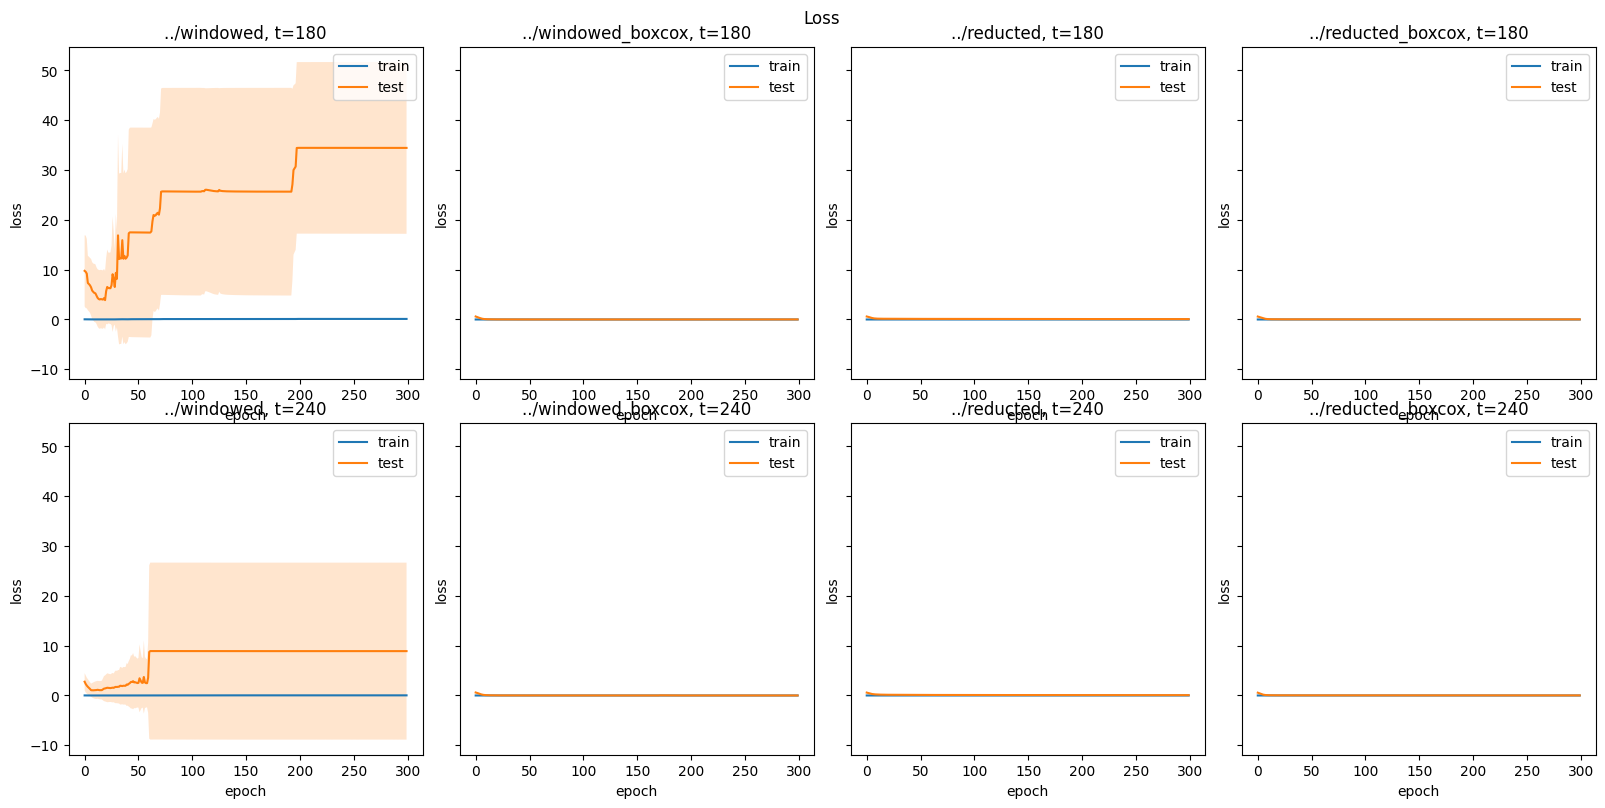

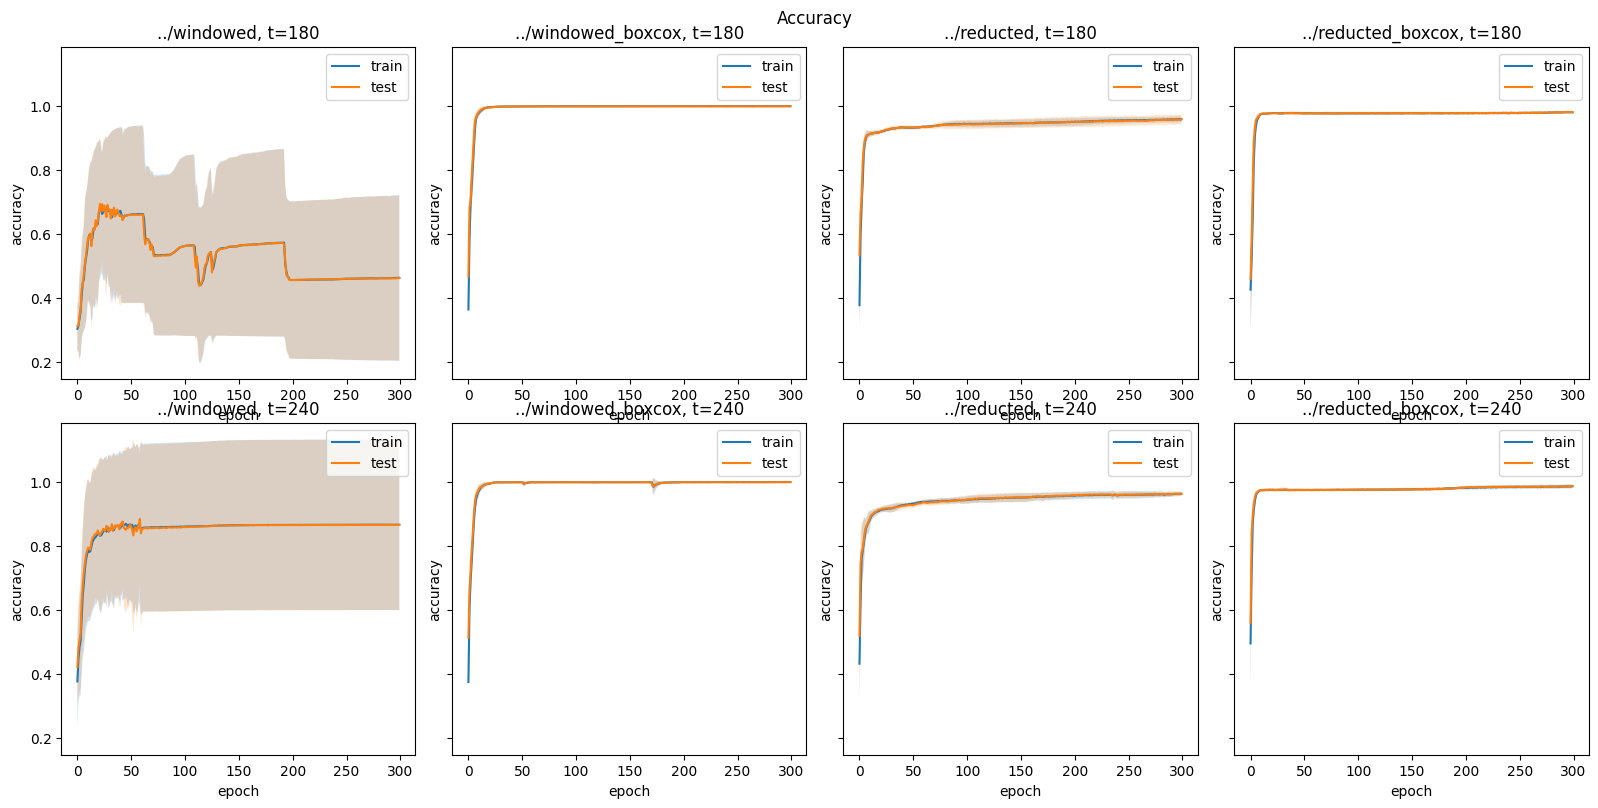

,directory,time_window,train_loss,test_loss,train_acc,test_acc
0,../windowed,180,0.114815,34.451253,0.463111,0.462444
1,../windowed,240,0.029642,8.908966,0.866361,0.865889
2,../windowed_boxcox,180,0.000005,0.014470,0.999611,0.999000
3,../windowed_boxcox,240,0.000006,0.004162,0.999861,0.999333
4,../reducted,180,0.000263,0.079865,0.958222,0.959222
5,../reducted,240,0.000226,0.069384,0.963028,0.962667
6,../reducted_boxcox,180,0.000074,0.023973,0.980111,0.980556
7,../reducted_boxcox,240,0.000059,0.018237,0.987222,0.986556


In [14]:
DIRECTORIES = ["../windowed", "../windowed_boxcox", "../reducted", "../reducted_boxcox"]
TIME_WINDOWS = [180, 240]
DEVICE = torch.device("cpu")

DATA_SIZE = 3000
GROUPBY = "label"
TRAIN_RATIO = 0.6
BATCH_SIZE = 300
EPOCHS = 300

# プロットの初期化
fig_loss, axes_loss = plt.subplots(
    len(TIME_WINDOWS), len(DIRECTORIES), figsize=(4 * len(DIRECTORIES) + 1, 4 * len(TIME_WINDOWS) + 1), sharey=True, squeeze=False
)
fig_loss.suptitle("Loss")
plt.tight_layout()
fig_acc, axes_acc = plt.subplots(
    len(TIME_WINDOWS), len(DIRECTORIES), figsize=(4 * len(DIRECTORIES) + 1, 4 * len(TIME_WINDOWS) + 1), sharey=True, squeeze=False
)
fig_acc.suptitle("Accuracy")
plt.tight_layout()

# 結果表の初期化
result = pd.DataFrame(
    columns=[
        "directory",
        "time_window",
        "train_loss",
        "test_loss",
        "train_acc",
        "test_acc",
    ]
)

# モデルの保存用辞書
model_dict = OrderedDict()

# モデルの訓練
skf = skms.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for i, directory in enumerate(DIRECTORIES):
    for j, time_window in enumerate(TIME_WINDOWS):
        # データの読み込み
        dataset = AquatanBleDataset([f"{directory}/t={time_window}.csv"], GROUPBY, DATA_SIZE)

        # 交差検証
        train_losses_list = []
        test_losses_list = []
        train_accs_list = []
        test_accs_list = []
        for l, (train_index, test_index) in enumerate(skf.split(dataset.X, torch.argmax(dataset.t, dim=1))):
            train_dataset = torch.utils.data.Subset(dataset, train_index)
            test_dataset = torch.utils.data.Subset(dataset, test_index)
            train_loader = torch.utils.data.DataLoader(
                train_dataset, batch_size=BATCH_SIZE, shuffle=True
            )
            test_loader = torch.utils.data.DataLoader(
                test_dataset, batch_size=len(test_dataset), shuffle=False
            )

            # モデルの定義
            model = AquatanBleNN(input_dim=dataset.X.shape[1], hidden_dim=10, output_dim=dataset.t.shape[1])
            criterion = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters())

            # 訓練
            train_losses, test_losses, train_accs, test_accs = train(
                model, criterion, optimizer, train_loader, test_loader, EPOCHS, DEVICE
            )
            train_losses_list.append(train_losses)
            test_losses_list.append(test_losses)
            train_accs_list.append(train_accs)
            test_accs_list.append(test_accs)


        # 結果のプロット
        plot_mean_std(axes_loss[j, i], train_losses_list, "train")
        plot_mean_std(axes_loss[j, i], test_losses_list, "test")
        axes_loss[j, i].set_title(f"{directory}, t={time_window}")
        axes_loss[j, i].set_xlabel("epoch")
        axes_loss[j, i].set_ylabel("loss")
        axes_loss[j, i].legend()
        plot_mean_std(axes_acc[j, i], train_accs_list, "train")
        plot_mean_std(axes_acc[j, i], test_accs_list, "test")
        axes_acc[j, i].set_title(f"{directory}, t={time_window}")
        axes_acc[j, i].set_xlabel("epoch")
        axes_acc[j, i].set_ylabel("accuracy")
        axes_acc[j, i].legend()

        # 結果表の更新
        result.loc[len(result)] = [
            directory,
            time_window,
            np.mean(train_losses_list, axis=0)[-1],
            np.mean(test_losses_list, axis=0)[-1],
            np.mean(train_accs_list, axis=0)[-1],
            np.mean(test_accs_list, axis=0)[-1],
        ]

        # # モデルの保存
        # model_dict[f"{directory}/t={time_window}"] = model
        
        print(f"{directory}, t={time_window} finished")

plt.show()
display(result)

## ハイパーパラメータの調整

../windowed_boxcox, t=180 hidden_dim=2 finished
../windowed_boxcox, t=180 hidden_dim=3 finished
../windowed_boxcox, t=180 hidden_dim=4 finished
../windowed_boxcox, t=180 hidden_dim=5 finished
../windowed_boxcox, t=180 hidden_dim=6 finished
../windowed_boxcox, t=180 hidden_dim=7 finished
../windowed_boxcox, t=180 hidden_dim=8 finished
../windowed_boxcox, t=180 hidden_dim=9 finished
../windowed_boxcox, t=180 hidden_dim=10 finished
../reducted_boxcox, t=180 hidden_dim=2 finished
../reducted_boxcox, t=180 hidden_dim=3 finished
../reducted_boxcox, t=180 hidden_dim=4 finished
../reducted_boxcox, t=180 hidden_dim=5 finished
../reducted_boxcox, t=180 hidden_dim=6 finished
../reducted_boxcox, t=180 hidden_dim=7 finished
../reducted_boxcox, t=180 hidden_dim=8 finished
../reducted_boxcox, t=180 hidden_dim=9 finished
../reducted_boxcox, t=180 hidden_dim=10 finished


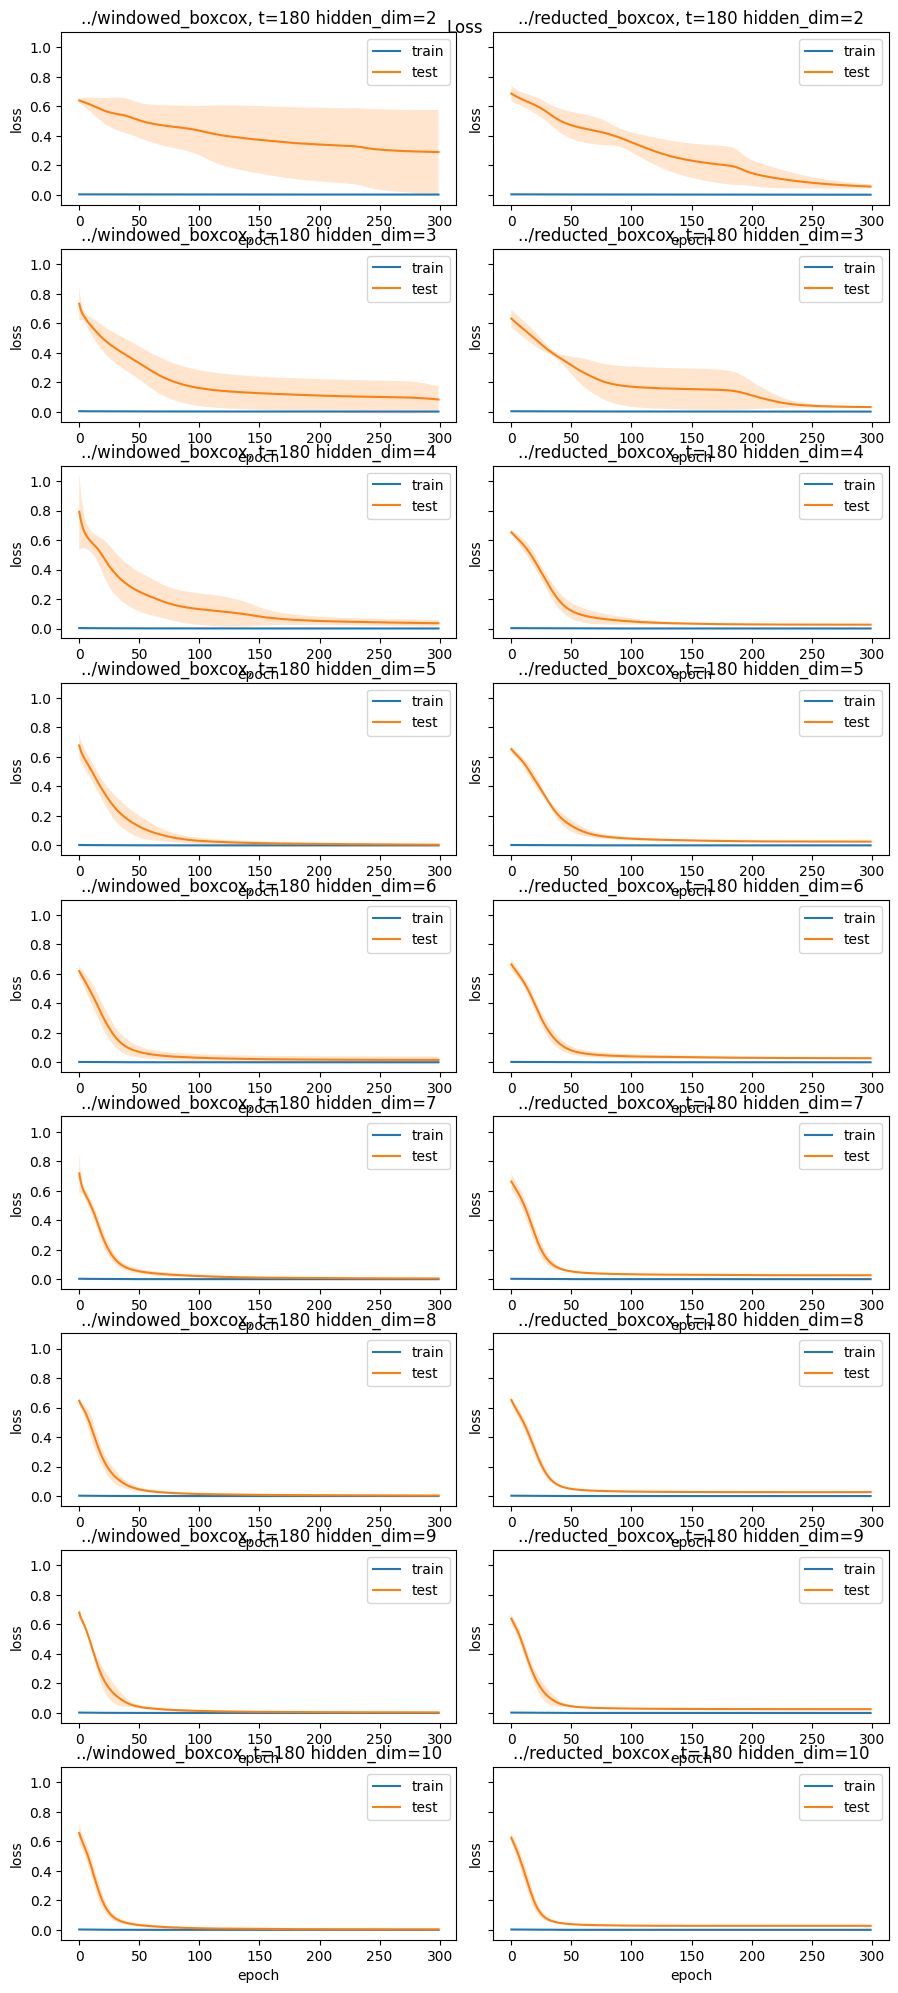

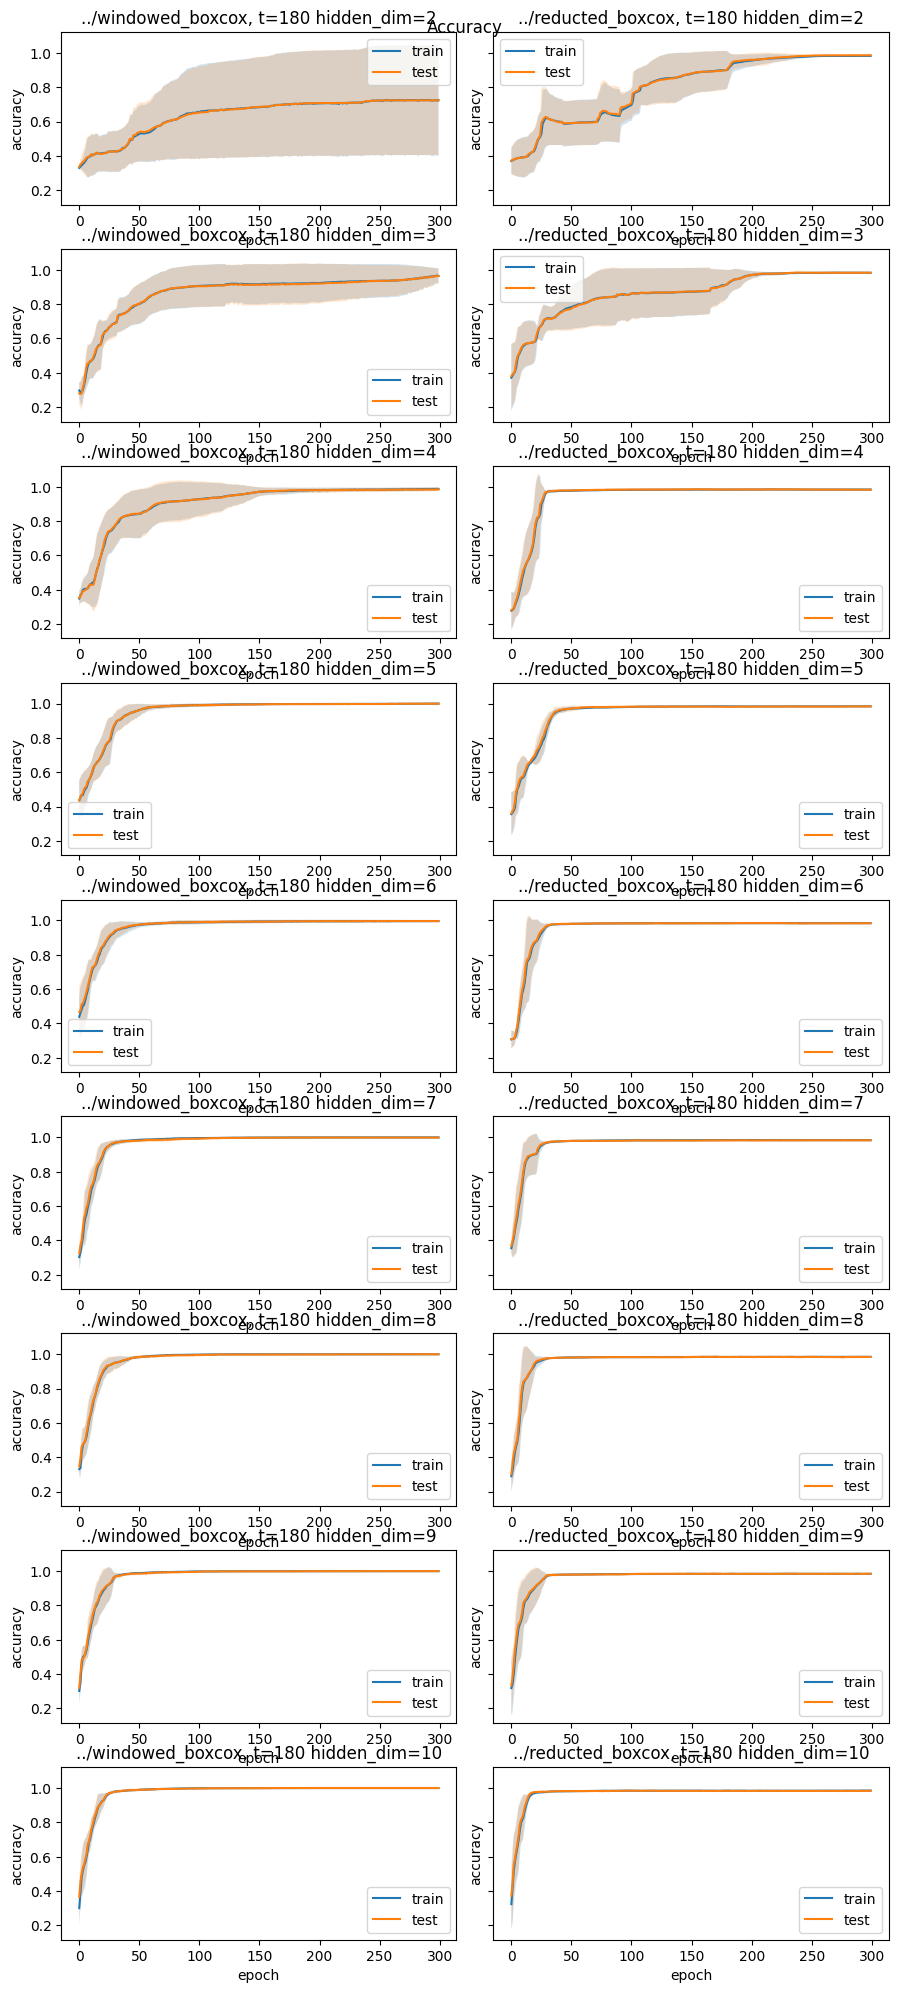

,directory,time_window,hidden_dim,train_loss,test_loss,train_acc,test_acc
0,../windowed_boxcox,180,2,0.001047,0.289136,0.725104,0.723333
1,../windowed_boxcox,180,3,0.000284,0.081929,0.963750,0.963750
2,../windowed_boxcox,180,4,0.000123,0.035643,0.986563,0.983750
3,../windowed_boxcox,180,5,0.000015,0.004610,0.999271,0.998750
4,../windowed_boxcox,180,6,0.000049,0.015963,0.996146,0.996250
5,../windowed_boxcox,180,7,0.000010,0.004598,0.999479,0.998333
6,../windowed_boxcox,180,8,0.000007,0.003726,0.999583,0.999583
7,../windowed_boxcox,180,9,0.000008,0.003454,0.999583,0.999583
8,../windowed_boxcox,180,10,0.000007,0.002991,0.999583,0.999583
9,../reducted_boxcox,180,2,0.000207,0.055171,0.982187,0.986250


In [20]:
DIRECTORIES = ["../windowed_boxcox", "../reducted_boxcox"]
TIME_WINDOWS = [180]
DEVICE = torch.device("cpu")

DATA_SIZE = 80
GROUPBY = ["label", "ble_id"]
TRAIN_RATIO = 0.6
BATCH_SIZE = 300
EPOCHS = 300

HIDDEN_DIMS = [2, 3, 4, 5, 6, 7, 8, 9, 10]

PLT_ROWS = len(HIDDEN_DIMS)
PLT_COLS = len(DIRECTORIES) * len(TIME_WINDOWS)

# プロットの初期化
fig_loss, axes_loss = plt.subplots(
    PLT_ROWS, PLT_COLS, figsize=(4 * PLT_COLS + 1, 2 * PLT_ROWS + 2), sharex=True, sharey=True, squeeze=False
)
fig_loss.suptitle("Loss")
plt.tight_layout()
fig_acc, axes_acc = plt.subplots(
    PLT_ROWS, PLT_COLS, figsize=(4 * PLT_COLS + 1, 2 * PLT_ROWS + 2), sharex=True, sharey=True, squeeze=False
)
fig_acc.suptitle("Accuracy")
plt.tight_layout()

# 結果表の初期化
result = pd.DataFrame(
    columns=[
        "directory",
        "time_window",
        "hidden_dim",
        "train_loss",
        "test_loss",
        "train_acc",
        "test_acc",
    ]
)

# モデルの訓練
skf = skms.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for i, directory in enumerate(DIRECTORIES):
    for j, time_window in enumerate(TIME_WINDOWS):
        # データの読み込み
        dataset = AquatanBleDataset([f"{directory}/t={time_window}.csv"], GROUPBY, DATA_SIZE)

        for k, hidden_dim in enumerate(HIDDEN_DIMS):
            # 交差検証
            train_losses_list = []
            test_losses_list = []
            train_accs_list = []
            test_accs_list = []
            for train_index, test_index in skf.split(dataset.X, torch.argmax(dataset.t, dim=1)):
                train_dataset = torch.utils.data.Subset(dataset, train_index)
                test_dataset = torch.utils.data.Subset(dataset, test_index)
                train_loader = torch.utils.data.DataLoader(
                    train_dataset, batch_size=BATCH_SIZE, shuffle=True
                )
                test_loader = torch.utils.data.DataLoader(
                    test_dataset, batch_size=len(test_dataset), shuffle=False
                )

                # モデルの定義
                model = AquatanBleNN(input_dim=dataset.X.shape[1], hidden_dim=hidden_dim, output_dim=dataset.t.shape[1])
                criterion = nn.BCELoss()
                optimizer = torch.optim.Adam(model.parameters())

                # 訓練
                train_losses, test_losses, train_accs, test_accs = train(
                    model, criterion, optimizer, train_loader, test_loader, EPOCHS, DEVICE
                )
                train_losses_list.append(train_losses)
                test_losses_list.append(test_losses)
                train_accs_list.append(train_accs)
                test_accs_list.append(test_accs)


            # 結果表の更新
            result.loc[len(result)] = [
                directory,
                time_window,
                hidden_dim,
                np.mean(train_losses_list, axis=0)[-1],
                np.mean(test_losses_list, axis=0)[-1],
                np.mean(train_accs_list, axis=0)[-1],
                np.mean(test_accs_list, axis=0)[-1],
            ]

            # 結果のプロット
            plot_mean_std(axes_loss[k, i * len(TIME_WINDOWS) + j], train_losses_list, "train")
            plot_mean_std(axes_loss[k, i * len(TIME_WINDOWS) + j], test_losses_list, "test")
            axes_loss[k, i * len(TIME_WINDOWS) + j].set_title(f"{directory}, t={time_window} hidden_dim={hidden_dim}")
            axes_loss[k, i * len(TIME_WINDOWS) + j].set_xlabel("epoch")
            axes_loss[k, i * len(TIME_WINDOWS) + j].set_ylabel("loss")
            axes_loss[k, i * len(TIME_WINDOWS) + j].legend()
            plot_mean_std(axes_acc[k, i * len(TIME_WINDOWS) + j], train_accs_list, "train")
            plot_mean_std(axes_acc[k, i * len(TIME_WINDOWS) + j], test_accs_list, "test")
            axes_acc[k, i * len(TIME_WINDOWS) + j].set_title(f"{directory}, t={time_window} hidden_dim={hidden_dim}")
            axes_acc[k, i * len(TIME_WINDOWS) + j].set_xlabel("epoch")
            axes_acc[k, i * len(TIME_WINDOWS) + j].set_ylabel("accuracy")
            axes_acc[k, i * len(TIME_WINDOWS) + j].legend()
            
            # # モデルの保存
            # model_dict[f"{directory}/t={time_window}"] = model
            
            print(f"{directory}, t={time_window} hidden_dim={hidden_dim} finished")

plt.tight_layout()
plt.show()
display(result)

In [8]:
# モデルの出力を確認
DATA_SIZE = 10
model.eval()
dataset = AquatanBleDataset(data_paths, DATA_SIZE)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
x, t = next(iter(data_loader))
y = model(x)
argmax_y = torch.argmax(y, dim=1)
argmax_t = torch.argmax(t, dim=1)
df = pd.DataFrame({
    "True": argmax_t.numpy(),
    "Predict": argmax_y.numpy()
})
pd.concat([pd.DataFrame(x.numpy()), df, pd.DataFrame(y.detach().numpy())], axis=1)

NameError: name 'data_paths' is not defined

In [ ]:
# モデルの保存
OUTPUT_FILE = f"../model/model_t={TIME_WINDOW}.pth"
torch.save(model.state_dict(), OUTPUT_FILE)